In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook
import torch

In [3]:
from model import SmallNet

parallel_data = True

prefix = 'models/burlington_batch4_scheduledLR2_'
num_files = -1
model_type = SmallNet

In [4]:
n_channels = 4

In [50]:
%env CUDA_VISIBLE_DEVICES=4
checkpoint = torch.load(prefix + 'final_model.mdl')
model = model_type(n_channels=2*n_channels, concat_features=False)
model.cuda()
if parallel_data:
    model = torch.nn.DataParallel(model)
model.load_state_dict(checkpoint['state_dict'], strict=False)

env: CUDA_VISIBLE_DEVICES=4


IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [51]:
%env CUDA_VISIBLE_DEVICES=4

checkpoint2 = torch.load(prefix + 'early_stop.mdl')
model2 = model_type(n_channels=2*n_channels, concat_features=False)
model2.cuda()
if parallel_data:
    model2 = torch.nn.DataParallel(model2)
model2.load_state_dict(checkpoint2['state_dict'], strict=False)

env: CUDA_VISIBLE_DEVICES=4


IncompatibleKeys(missing_keys=[], unexpected_keys=[])

In [8]:
from train_5qubit import circuit_to_image, family_to_images

In [9]:
import torchvision.transforms as transforms
from model import CircuitPairDataset
from torch.utils.data import DataLoader
import glob

noise_file = 'supremacy_all_5_unique/burlington_noise.npy'
circuits_file = 'supremacy_all_5_unique/circuits.npy'


np_target = np.load(noise_file)
np_data = []
raw_data = np.load(circuits_file)
for f in raw_data:
    np_data.append(family_to_images(f))

np_data = np.array(np_data)

In [10]:
print('data shape', np_data.shape)
print('target shape', np_target.shape)

# shuffle to remove time ordering of runs
np.random.seed(0)
order = np.arange(np_data.shape[0])
np.random.shuffle(order)
np_data = np_data[order]
np_target = np_target[order]


# normalize data
channel_mean = np.mean(np_data, axis=(0, 1, 3, 4))
channel_stdev = np.std(np_data, axis=(0, 1, 3, 4))
transform = transforms.Normalize(channel_mean, channel_stdev)

data shape (1000, 16, 4, 44, 5)
target shape (1000, 16)


In [11]:
train_fraction = 0.8
validate_fraction = 0.1

train_len = int(train_fraction*len(np_data))
valid_len = int(validate_fraction*len(np_data))

train_circuits = np_data[:train_len]
train_target = np_target[:train_len]
valid_circuits = np_data[train_len + valid_len:]
valid_target = np_target[train_len + valid_len:]
test_circuits = np_data[train_len:train_len + valid_len]
test_target = np_target[train_len:train_len + valid_len]

transform = transforms.Normalize(channel_mean, channel_stdev)
# train_dataset = CircuitPairDataset(train_circuits, train_target, transform=transform)
# train_loader = DataLoader(train_dataset, batch_size=512, shuffle=False, num_workers=2, pin_memory=torch.cuda.is_available())
valid_dataset = CircuitPairDataset(valid_circuits, valid_target, transform=transform, reflect=False)
valid_loader = DataLoader(valid_dataset, batch_size=512, shuffle=False, num_workers=2, pin_memory=torch.cuda.is_available())
test_dataset = CircuitPairDataset(test_circuits, test_target, transform=transform, reflect=False)
test_loader = DataLoader(test_dataset, batch_size=512, shuffle=False, num_workers=2, pin_memory=torch.cuda.is_available())

In [12]:
model.eval()
predictions_final = np.zeros(0)
for i, data in enumerate(test_loader, 0):
    inputs, circuit_lengths, target = data
    inputs = inputs.cuda()
    circuit_lengths = circuit_lengths.cuda()
    outputs = model(inputs)
    target = np.reshape(target.numpy(), len(target))
    outputs = outputs.cpu().detach().numpy()
    outputs = np.reshape(outputs, len(outputs))
    
    predictions_final = np.append(predictions_final, outputs)

In [52]:
labels = np.zeros(0)
model2.eval()
predictions_early = np.zeros(0)
for i, data in enumerate(test_loader, 0):
    inputs, circuit_lengths, target = data
    inputs = inputs.cuda()
    circuit_lengths = circuit_lengths.cuda()
    outputs = model2(inputs)
    outputs = outputs.cpu().detach().numpy()
    outputs = np.reshape(outputs, len(outputs))
    
    labels = np.append(labels, target)
    predictions_early = np.append(predictions_early, outputs)

In [14]:
model.eval()
valid_predictions_final = np.zeros(0)
for i, data in enumerate(valid_loader, 0):
    inputs, circuit_lengths, target = data
    inputs = inputs.cuda()
    circuit_lengths = circuit_lengths.cuda()
    outputs = model(inputs)
    target = np.reshape(target.numpy(), len(target))
    outputs = outputs.cpu().detach().numpy()
    outputs = np.reshape(outputs, len(outputs))
    
    valid_predictions_final = np.append(valid_predictions_final, outputs)

In [53]:
valid_labels = np.zeros(0)
model2.eval()
valid_predictions_early = np.zeros(0)
for i, data in enumerate(valid_loader, 0):
    inputs, circuit_lengths, target = data
    inputs = inputs.cuda()
    circuit_lengths = circuit_lengths.cuda()
    outputs = model2(inputs)
    outputs = outputs.cpu().detach().numpy()
    outputs = np.reshape(outputs, len(outputs))
    
    valid_labels = np.append(valid_labels, target)
    valid_predictions_early = np.append(valid_predictions_early, outputs)

In [16]:
def bin_data(d, plot_labels):
    sorter = np.argsort(d)
    grouped_labels = np.split(plot_labels[sorter], np.cumsum(np.unique(d[sorter], return_counts=True)[1])[:-1])
    x_values = np.unique(d[sorter])
    averages = np.zeros(len(x_values))
    stdevs = np.zeros(len(x_values))
    for i in range(len(grouped_labels)):
        averages[i] = np.average(grouped_labels[i])
        stdevs[i] = np.std(grouped_labels[i])/np.sqrt(len(grouped_labels[i]))
    return x_values, averages, stdevs

In [17]:
def plot_all(predicted, target):
    max_lim = np.amax(target)
    min_lim = np.amin(target)
    plt.figure()
    plt.scatter(target, predicted, alpha=0.1)
    x = np.linspace(min_lim, max_lim)
    plt.plot(x, x, color='orange')
    plt.xlim((min_lim, max_lim))
    plt.ylim((min_lim, max_lim))
    plt.xlabel('True ' + 'noise')
    plt.ylabel('Predicted ' + 'noise')
    plt.show()

In [18]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error, median_absolute_error

def show_results(predicted, target):
    print('MSE:', mean_squared_error(target, predicted))
    print('MAE:', mean_absolute_error(target, predicted))
    print('R^2:', r2_score(target, predicted))
    plot_all(predicted, target)

In [19]:
def predict(circuit_pairs, target, asymmetric_predictions):
    pairs = target[np.unravel_index(circuit_pairs, target.shape)]
    shaped_target = pairs[:, 1] - pairs[:, 0]
    reverse_inds = np.zeros(len(pairs)).astype(int)
    for i in range(len(pairs)):
        b, a = circuit_pairs[i]
        ind = (a - a//16)*15 + (b - b//16)
        if a < b:
            ind -= 1
        reverse_inds[i] = ind
    predictions_ensemble = (asymmetric_predictions - asymmetric_predictions[reverse_inds])/2
    return predictions_ensemble, shaped_target

In [54]:
valid_flat_preds, valid_flat_target = predict(valid_dataset.circuit_pairs, valid_target, valid_predictions_early)
test_flat_preds, test_flat_target = predict(test_dataset.circuit_pairs, test_target, predictions_early)

MSE: 0.0023754060378294037
MAE: 0.03560083960875546
R^2: 0.658175525812722


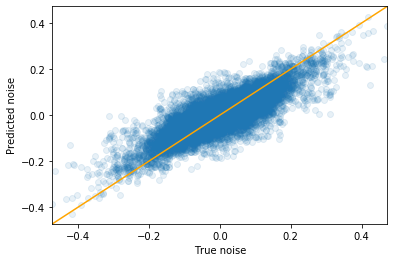

In [56]:
show_results(test_flat_preds, test_flat_target)

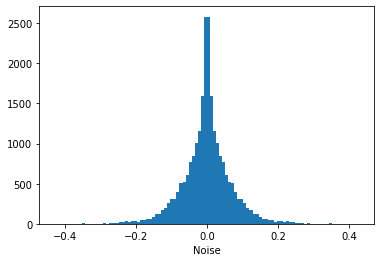

In [48]:
plt.figure()
plt.hist(test_flat_preds, bins=100)
plt.xlabel('Noise')
plt.show()

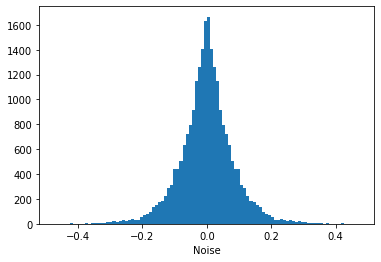

In [49]:
plt.figure()
plt.hist(test_flat_target, bins=100)
plt.xlabel('Noise')
plt.show()

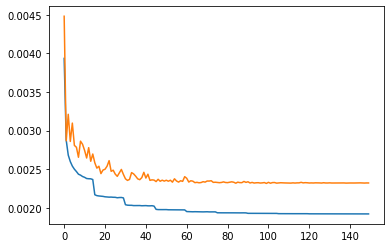

In [58]:
train_loss = checkpoint['loss_history'][0]
valid_loss = checkpoint['loss_history'][1]
plt.figure()
plt.plot(train_loss[np.where(train_loss != 0)])
plt.plot(valid_loss[np.where(train_loss != 0)])
# plt.ylim(0, 0.75)
plt.show()